<a href="https://colab.research.google.com/github/alisanyalcinn/object-detection-YOLO/blob/main/YOLOv8_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alianyaln","key":"887656a8cc60f125307147d8503f4e4f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!mkdir -p ./data/pascal_voc
!kaggle datasets download -d sulaimannadeem/pascal-voc-2008
!unzip pascal-voc-2008.zip -d ./data/pascal_voc

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: ./data/pascal_voc/Pascal Dataset/JPEGImages/2007_001558.jpg  
  inflating: ./data/pascal_voc/Pascal Dataset/JPEGImages/2007_001568.jpg  
  inflating: ./data/pascal_voc/Pascal Dataset/JPEGImages/2007_001583.jpg  
  inflating: ./data/pascal_voc/Pascal Dataset/JPEGImages/2007_001585.jpg  
  inflating: ./data/pascal_voc/Pascal Dataset/JPEGImages/2007_001586.jpg  
  inflating: ./data/pascal_voc/Pascal Dataset/JPEGImages/2007_001587.jpg  
  inflating: ./data/pascal_voc/Pascal Dataset/JPEGImages/2007_001594.jpg  
  inflating: ./data/pascal_voc/Pascal Dataset/JPEGImages/2007_001595.jpg  
  inflating: ./data/pascal_voc/Pascal Dataset/JPEGImages/2007_001602.jpg  
  inflating: ./data/pascal_voc/Pascal Dataset/JPEGImages/2007_001609.jpg  
  inflating: ./data/pascal_voc/Pascal Dataset/JPEGImages/2007_001627.jpg  
  inflating: ./data/pascal_voc/Pascal Dataset/JPEGImages/2007_001630.jpg  
  inflating: ./data/pascal_voc/Pascal Dataset/JPEGIma

In [ ]:
import cv2, numpy as np, xml.etree.ElementTree as ET
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [ ]:
image_files = glob('/content/data/pascal_voc/Pascal_Dataset/JPEGImages/*.jpg')
annotation_files = glob('/content/data/pascal_voc/Pascal_Dataset/Annotations/*.xml')

In [ ]:
!pip install ultralytics
!pip install lxml

In [ ]:
import os
import glob
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

In [ ]:
image_dir = "/content/data/pascal_voc/Pascal Dataset/JPEGImages"
annotation_dir = "/content/data/pascal_voc/Pascal Dataset/Annotations"
output_dir = "/content/data/pascal_voc_yolo"
os.makedirs(f"{output_dir}/images/train", exist_ok=True)
os.makedirs(f"{output_dir}/images/val", exist_ok=True)
os.makedirs(f"{output_dir}/images/test", exist_ok=True)
os.makedirs(f"{output_dir}/labels/train", exist_ok=True)
os.makedirs(f"{output_dir}/labels/val", exist_ok=True)
os.makedirs(f"{output_dir}/labels/test", exist_ok=True)

In [ ]:
def convert_bbox(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    return (x * dw, y * dh, w * dw, h * dh)

In [ ]:
from sklearn.model_selection import train_test_split


image_files = glob.glob(f"{image_dir}/*.jpg")

train_files, temp_files = train_test_split(image_files, test_size=0.3, random_state=42)


val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)


print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

Train: 3567, Val: 764, Test: 765


In [ ]:
import shutil
import os

def copy_images(file_list, split):
    split_dir = f"/content/data/pascal_voc_yolo/images/{split}"
    os.makedirs(split_dir, exist_ok=True)
    for file_path in file_list:
        filename = os.path.basename(file_path)
        shutil.copy(file_path, os.path.join(split_dir, filename))


copy_images(train_files, "train")
copy_images(val_files, "val")
copy_images(test_files, "test")

In [ ]:
import os
import xml.etree.ElementTree as ET
import shutil
from glob import glob

annotation_dir = "/content/data/pascal_voc/Pascal Dataset/Annotations"
output_dir = "/content/data/pascal_voc_yolo"
classes = []

In [ ]:
def convert_bbox(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    return (x * dw, y * dh, w * dw, h * dh)

In [ ]:
def convert_annotation(image_path, split):
    filename = os.path.basename(image_path).replace(".jpg", "")
    xml_path = os.path.join(annotation_dir, filename + ".xml")
    label_path = os.path.join(output_dir, f"labels/{split}/{filename}.txt")

    if not os.path.exists(xml_path):
        print(f"⚠️ Skipping (no annotation): {xml_path}")
        return

    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        size = root.find("size")
        w, h = float(size.find("width").text), float(size.find("height").text)

        with open(label_path, 'w') as out_file:
            for obj in root.iter("object"):
                cls = obj.find("name").text
                if cls not in classes:
                    classes.append(cls)
                cls_id = classes.index(cls)
                xmlbox = obj.find("bndbox")
                b = [float(xmlbox.find(tag).text) for tag in ["xmin", "xmax", "ymin", "ymax"]]
                bb = convert_bbox((w, h), b)
                out_file.write(f"{cls_id} " + " ".join([f"{a:.6f}" for a in bb]) + "\n")
    except Exception as e:
        print(f"❌ Error with {xml_path}: {e}")

In [ ]:
def process_split(split):
    img_dir = os.path.join(output_dir, f"images/{split}")
    label_dir = os.path.join(output_dir, f"labels/{split}")
    os.makedirs(label_dir, exist_ok=True)

    image_files = glob(f"{img_dir}/*.jpg")

    print(f"Processing {split} set: {len(image_files)} images")
    for img_path in image_files:
        convert_annotation(img_path, split)

    print(f"✅ Done: {split} → {len(os.listdir(label_dir))} labels created.")

In [ ]:
for split in ["train", "val", "test"]:
    process_split(split)

Processing train set: 3567 images
✅ Done: train → 3567 labels created.
Processing val set: 764 images
✅ Done: val → 764 labels created.
Processing test set: 765 images
✅ Done: test → 765 labels created.


In [ ]:
data_yaml_content = f"""
train: {output_dir}/images/train
val: {output_dir}/images/val
test: {output_dir}/images/test

nc: {len(classes)}
names: {classes}
"""

yaml_path = os.path.join(output_dir, "data.yaml")
with open(yaml_path, "w") as f:
    f.write(data_yaml_content)

print("✅ data.yaml created at:", yaml_path)

✅ data.yaml created at: /content/data/pascal_voc_yolo/data.yaml


In [ ]:
with open(yaml_path, "r") as f:
    print(f.read())


train: /content/data/pascal_voc_yolo/images/train
val: /content/data/pascal_voc_yolo/images/val
test: /content/data/pascal_voc_yolo/images/test

nc: 20
names: ['person', 'bicycle', 'car', 'cat', 'motorbike', 'boat', 'aeroplane', 'dog', 'tvmonitor', 'horse', 'bird', 'sofa', 'bus', 'chair', 'diningtable', 'pottedplant', 'bottle', 'sheep', 'train', 'cow']



In [ ]:
from ultralytics import YOLO


model = YOLO("yolov8s.pt")


model.train(
    data=f"{output_dir}/data.yaml",
    epochs=10,
    imgsz=416,
    batch=16,
    name="yolov8_pascal_voc"
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 373MB/s]


Ultralytics 8.3.151 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data/pascal_voc_yolo/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_pascal_voc, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, po

100%|██████████| 755k/755k [00:00<00:00, 69.1MB/s]

Overriding model.yaml nc=80 with nc=20

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

 22        [15, 18, 21]  1   2123788  ultralytics.nn.modules.head.Detect           [20, [128, 256, 512]]         
Model summary: 129 layers, 11,143,340 parameters, 11,143,324 gradients, 28.7 GFLOPs

Transferred 349/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1370.9±1065.6 MB/s, size: 110.1 KB)


train: Scanning /content/data/pascal_voc_yolo/labels/train... 3567 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3567/3567 [00:01<00:00, 1796.91it/s]

train: New cache created: /content/data/pascal_voc_yolo/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 687.4±272.6 MB/s, size: 78.8 KB)


val: Scanning /content/data/pascal_voc_yolo/labels/val... 764 images, 0 backgrounds, 0 corrupt: 100%|██████████| 764/764 [00:00<00:00, 1889.04it/s]

val: New cache created: /content/data/pascal_voc_yolo/labels/val.cache


Plotting labels to runs/detect/yolov8_pascal_voc/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs/detect/yolov8_pascal_voc
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G     0.9346      1.893      1.124         58        416: 100%|██████████| 223/223 [55:08<00:00, 14.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:29<00:00,  8.75s/it]

                   all        764       2055      0.658      0.624      0.647      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G       1.01      1.342      1.164         50        416: 100%|██████████| 223/223 [54:17<00:00, 14.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:24<00:00,  8.53s/it]

                   all        764       2055      0.609      0.532      0.569      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.073      1.381      1.204         33        416: 100%|██████████| 223/223 [54:34<00:00, 14.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:22<00:00,  8.42s/it]

                   all        764       2055      0.563      0.544      0.533      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.074      1.308       1.21         35        416: 100%|██████████| 223/223 [54:25<00:00, 14.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:19<00:00,  8.33s/it]

                   all        764       2055      0.671      0.506      0.583      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G       1.02      1.186      1.179         34        416: 100%|██████████| 223/223 [53:19<00:00, 14.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:22<00:00,  8.42s/it]

                   all        764       2055      0.627      0.568      0.613      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G     0.9856      1.061      1.157         38        416: 100%|██████████| 223/223 [53:18<00:00, 14.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:19<00:00,  8.31s/it]

                   all        764       2055      0.699      0.568      0.644       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G     0.9358     0.9577      1.128         52        416: 100%|██████████| 223/223 [52:47<00:00, 14.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:17<00:00,  8.22s/it]

                   all        764       2055        0.7      0.585      0.644      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.8839     0.8691      1.093         32        416: 100%|██████████| 223/223 [52:48<00:00, 14.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:18<00:00,  8.28s/it]

                   all        764       2055       0.71      0.613      0.672      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G     0.8436     0.7924       1.07         34        416: 100%|██████████| 223/223 [53:16<00:00, 14.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:17<00:00,  8.25s/it]

                   all        764       2055      0.714      0.649       0.71      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.7979     0.7059      1.043         36        416: 100%|██████████| 223/223 [53:50<00:00, 14.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:22<00:00,  8.43s/it]

                   all        764       2055      0.779      0.641      0.721      0.537



10 epochs completed in 9.524 hours.
Optimizer stripped from runs/detect/yolov8_pascal_voc/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8_pascal_voc/weights/best.pt, 22.5MB

Validating runs/detect/yolov8_pascal_voc/weights/best.pt...
Ultralytics 8.3.151 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [03:06<00:00,  7.78s/it]


                   all        764       2055      0.781       0.64      0.721      0.537
                person        360        781      0.906      0.774      0.869      0.661
               bicycle         28         34      0.822      0.794      0.833       0.62
                   car         72        140      0.844      0.664      0.787      0.592
                   cat         72         82      0.907      0.837      0.875      0.761
             motorbike         36         52      0.903      0.769      0.846      0.556
                  boat         39         75      0.675      0.472      0.529      0.317
             aeroplane         33         54      0.845       0.63      0.674      0.498
                   dog         62         76      0.717      0.763      0.831      0.663
             tvmonitor         44         53      0.807      0.712      0.816       0.62
                 horse         44         63       0.93      0.778      0.881      0.695
                  bir

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b28a3054950>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043

In [ ]:
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt

In [ ]:
model_path = os.path.join("runs", "detect", "yolov8_pascal_voc", "weights", "best.pt")
model = YOLO(model_path)

In [ ]:
eval_results = model.val(data=f"{output_dir}/data.yaml")
print("\n📊 Evaluation Results:")
print(eval_results)

Ultralytics 8.3.151 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1145.2±468.3 MB/s, size: 82.9 KB)


val: Scanning /content/data/pascal_voc_yolo/labels/val.cache... 764 images, 0 backgrounds, 0 corrupt: 100%|██████████| 764/764 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [03:04<00:00,  3.84s/it]


                   all        764       2055      0.781      0.641      0.721      0.538
                person        360        781      0.904      0.774      0.869      0.662
               bicycle         28         34      0.799      0.794      0.836      0.624
                   car         72        140      0.852      0.664       0.79      0.593
                   cat         72         82      0.907      0.837      0.878      0.764
             motorbike         36         52      0.883      0.769      0.845      0.556
                  boat         39         75      0.675      0.472      0.526      0.316
             aeroplane         33         54      0.824       0.63      0.669      0.494
                   dog         62         76      0.717      0.763      0.837      0.669
             tvmonitor         44         53      0.807      0.712      0.817      0.617
                 horse         44         63       0.93      0.778      0.882        0.7
                  bir

In [ ]:
test_images = glob(f"{output_dir}/images/test/*.jpg")[:5]
results = model(test_images)


0: 416x416 1 aeroplane, 444.2ms
1: 416x416 2 persons, 1 horse, 444.2ms
2: 416x416 1 aeroplane, 444.2ms
3: 416x416 2 cats, 444.2ms
4: 416x416 2 birds, 444.2ms
Speed: 6.8ms preprocess, 444.2ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)


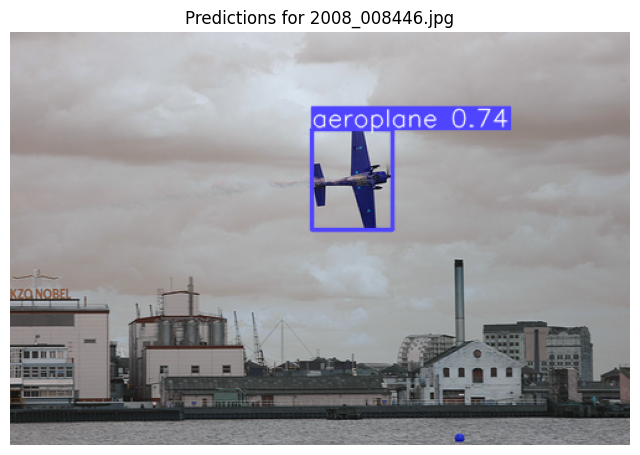

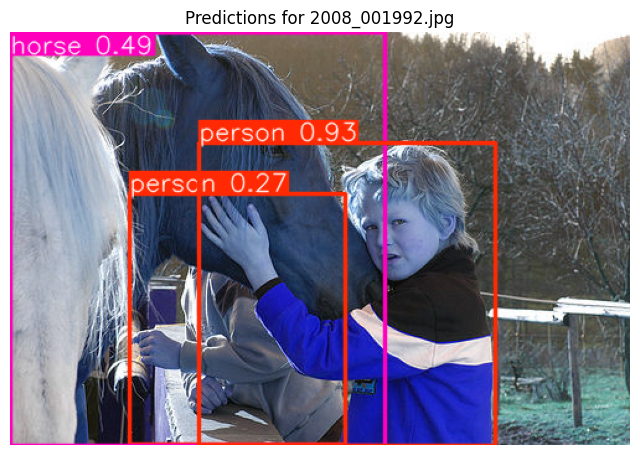

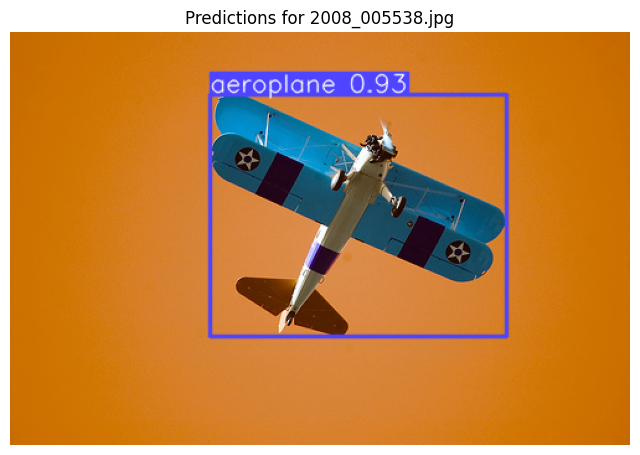

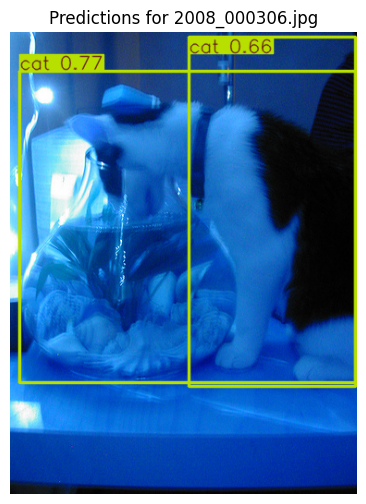

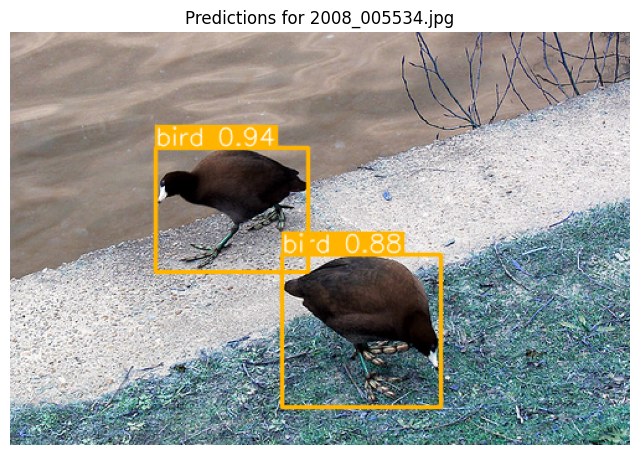

In [ ]:
for img_path, result in zip(test_images, results):
    im_array = result.plot()
    plt.figure(figsize=(8, 6))
    plt.imshow(im_array)
    plt.title(f"Predictions for {os.path.basename(img_path)}")
    plt.axis("off")
    plt.show()